In [ ]:
from collections import defaultdict
from pathlib import Path

import colorcet as cc
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import NeuralODE
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

EXP_TYPES_ALL = ("vanilla", "jacobian", "tangent_evolution", "neighborhood", "normal")
EXP_TYPES = ("vanilla", "jacobian", "tangent_evolution", "neighborhood")
COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        ("royalblue", "limegreen", "darkorange", "orangered", "saddlebrown"),
    )
)
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Vanilla",
            "Jacobian matching",
            "Tangent Evolution matching",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
        ),
    )
)

In [24]:
def load_experiment(
    exp_type: str,
    key: int,
    downsample: int = 2,
    train_length: int = 2,
    noise: float = 0.0,
    rootdir=Path("../../results/best/lorenz63"),
) -> NeuralODE:
    loaddir = rootdir / f"downsample={downsample}/len={train_length}/{exp_type}"
    model_paths = list(loaddir.glob(f"*_noise={noise}_key={key}*"))

    if len(model_paths) == 0:
        raise ValueError("No models found with the given conditions")
    elif len(model_paths) > 1:
        raise ValueError("Multiple models found with the given conditions!")
    else:
        return load_model(model_paths[0])


In [12]:
downsample = 2
noise = 0.0

datadir = Path("../../data")

dataset_train, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large_test.hdf5")
    .add_noise(noise)
    .apply_transform(transform)
)


In [ ]:
key = 0
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz63(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


jac_logerr_dict = defaultdict(list)
for train_len in tqdm((2, 3, 4, 5, 10, 15, 20, 30, 50)):
    jac_logerr_dict[train_len] = np.log10(
        compute_jac_err(load_experiment("vanilla", key, downsample, train_len, noise))
    )

100%|██████████| 9/9 [00:00<00:00, 14.79it/s]


Text(0, 0.5, '$\\log_{10}||\\mathbf{J}_{true}-\\mathbf{J}_{pred}||_F\\;/\\;||\\mathbf{J}_{true}||_F$')

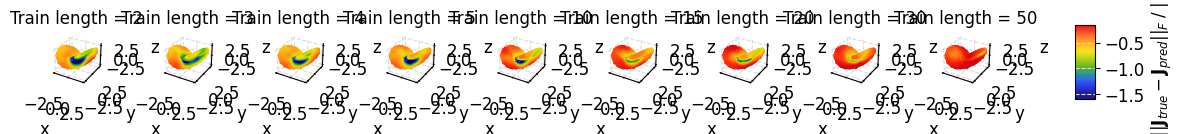

In [27]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0].T] * len(jac_logerr_dict),
    list(jac_logerr_dict.values()),
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)
for i, train_len in enumerate(jac_logerr_dict.keys()):
    fig.axes[i].set_title(f"Train length = {train_len}", fontsize="medium")
    set_labels(fig.axes[i], ["x", "y", "z"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)

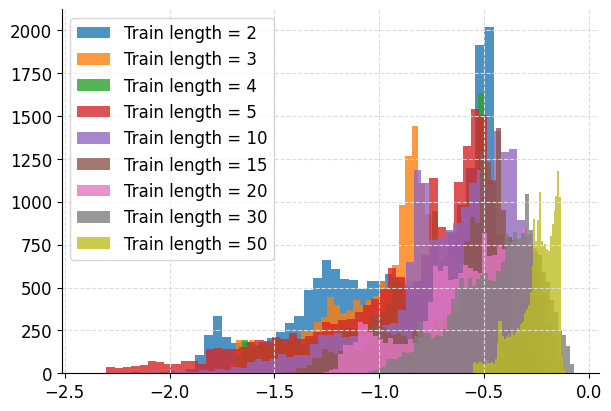

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for train_len, log_err in jac_logerr_dict.items():
    ax.hist(
        log_err,
        bins=50,
        label=f"Train length = {train_len}",
        alpha=0.8,
    )
ax.legend()

In [29]:
mean_errs = jax.tree.map(lambda x: np.median(10**x), jac_logerr_dict)
mean_errs

defaultdict(list,
            {2: np.float64(0.16271974278314677),
             3: np.float64(0.1430805942587095),
             4: np.float64(0.1819391445763444),
             5: np.float64(0.18683233190867005),
             10: np.float64(0.24447801581017892),
             15: np.float64(0.314825933178981),
             20: np.float64(0.30976140300454424),
             30: np.float64(0.39425974178196765),
             50: np.float64(0.5871741285424936)})

In [19]:
np.asarray(jac_logerr_dict.values())

array(dict_values([array([-0.57413856, -0.73438184, -0.56991466, ..., -1.10840282,
       -0.76877345, -1.10605038], shape=(20000,)), array([-0.7235454 , -0.67478268, -0.60490769, ..., -1.15588328,
       -0.92067879, -1.11402404], shape=(20000,)), array([-0.67107949, -0.68653788, -0.39805821, ..., -0.81254752,
       -0.83816359, -0.8696771 ], shape=(20000,)), array([-0.56342253, -0.5344142 , -0.2461273 , ..., -1.07915428,
       -0.82115738, -1.09771857], shape=(20000,)), array([-0.28345934, -0.25259769, -0.14410248, ..., -0.23113121,
       -0.26257635, -0.25541149], shape=(20000,)), array([ 0.13359511, -0.04470062, -0.04050991, ..., -0.04137587,
        0.12780916,  0.0715823 ], shape=(20000,))]), dtype=object)